## HOUSE PRICE PREDICTION ANALYSIS - TEHRAN HOUSE DATASET

In [1]:
#import needed libraries

#for data manipulations
import pandas as pd
import numpy as np

#for ploting data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid",font_scale=1.5)
#for statistical test
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
#for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")



# 1. Data Capture and Initial Analysis
---------------------------------------------------------------------------

In [2]:
#reading the data
#understanding data structure
housePrice=pd.read_csv("housePrice.csv")
housePrice.tail()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
3474,86,2,True,True,True,Southern Janatabad,3.500000e+09,116666.67
3475,83,2,True,True,True,Niavaran,6.800000e+09,226666.67
3476,75,2,False,False,False,Parand,3.650000e+08,12166.67
3477,105,2,True,True,True,Dorous,5.600000e+09,186666.67
3478,82,2,False,True,True,Parand,3.600000e+08,12000.00


## Exploratory Data Analysis

In [3]:
#checking the data infor
housePrice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


### Insights from the First Glance

{'Area': 'cat', 'Room': 'cat', 'Parking': 'cat', 'Warehouse': 'cat', 'Elevator': 'cat', 'Address': 'cat', 'Price': 'num', 'Price(USD)': 'num'}


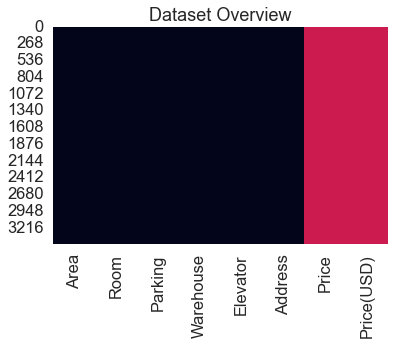

In [4]:
## Confirming the variables type that we are dealing with
#1. i want to recognised if a column is numeric or categorical data using a self defined function
def utils_recog_type(data,col,max_cat=20):
    if(data[col].dtype ==  "O") | (data[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"
    

#i want to plot heatmap to visualized columns type and missing data
dict_cols={col:utils_recog_type(housePrice, col, max_cat=20) for col in housePrice.columns }
print(dict_cols)

heatmap=housePrice.isnull()
#print(heatmap)

for k,v in dict_cols.items():
    if v=="num":
        heatmap[k]=heatmap[k].apply(lambda x:0.5 if x is False else 1)
    else:
        heatmap[k]=heatmap[k].apply(lambda x:0 if x is False else 1)
sns.heatmap(heatmap,cbar=False).set_title('Dataset Overview')
plt.show()

## PROBLEM TO SOLVE

In [5]:
dubSum=housePrice.duplicated().sum()
print (f' We have {dubSum} dublicated information')

 We have 208 dublicated information


### Missing Values

In [6]:
#percentage of missing that 
def mValue (data):
    m_number = data.isnull().sum().sort_values(ascending=False)
    m_percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    m_values = pd.concat([m_number, m_percent], axis=1, keys=['Missing Total', 'Missing %'])
    return m_values

mValue(housePrice)

,Missing Total,Missing %
Address,23,0.006611
Area,0,0.000000
Room,0,0.000000
Parking,0,0.000000
Warehouse,0,0.000000
Elevator,0,0.000000
Price,0,0.000000
Price(USD),0,0.000000


## Numerical Features in that data set

In [7]:
cat = ['Address', 'Area', 'Parking', 'Warehouse','Elevator']

num = ['Room','Price', 'Price(USD)']
housePrice[num].describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [8]:
#We can now check the skewness
housePrice[num].skew()

Room          0.626076
Price         4.779074
Price(USD)    4.779074
dtype: float64

## Univarate analysis

Text(0.5, 1.0, 'Price Distribution')

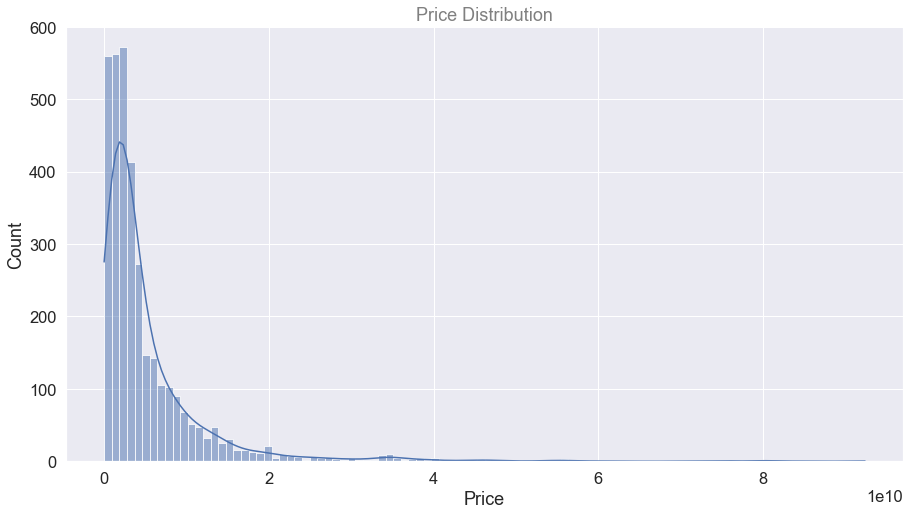

In [9]:
plt.figure(figsize=(15,8))
sns.histplot(x=housePrice["Price"] , kde=True,bins=100)
plt.title('Price Distribution' , color='gray')

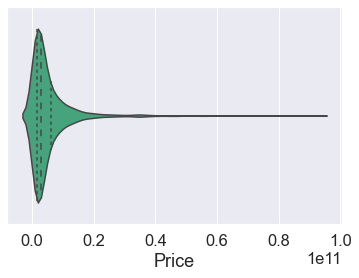

In [10]:

sns.violinplot(x=housePrice['Price'], inner="quartile", color="#36B37E");

<AxesSubplot:>

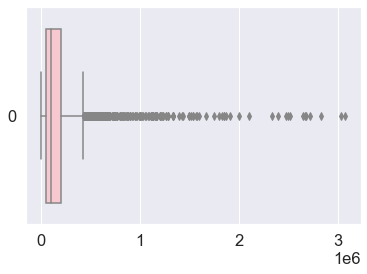

In [11]:
sns.boxplot(data=housePrice['Price(USD)'], orient='h', color='pink')

Text(0.5, 1.0, 'Number of Rooms')

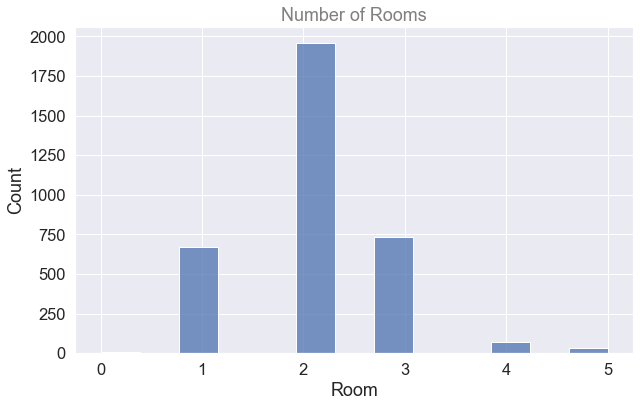

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(housePrice["Room"] , palette='Set2' )
plt.title("Number of Rooms" , color='gray')

## CATEGORICAL FEATURES

In [13]:
# ADDRESS

In [14]:
print(housePrice['Address'].value_counts())
housePrice['Address'].unique()


Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                141
Shahran                   130
                         ... 
Chardangeh                  1
Mehrabad                    1
Pakdasht KhatunAbad         1
Kazemabad                   1
Yakhchiabad                 1
Name: Address, Length: 192, dtype: int64


array(['Shahran', 'Pardis', 'Shahrake Qods', 'Shahrake Gharb',
       'North Program Organization', 'Andisheh', 'West Ferdows Boulevard',
       'Narmak', 'Saadat Abad', 'Zafar', 'Islamshahr', 'Pirouzi',
       'Shahrake Shahid Bagheri', 'Moniriyeh', 'Velenjak', 'Amirieh',
       'Southern Janatabad', 'Salsabil', 'Zargandeh', 'Feiz Garden',
       'Water Organization', nan, 'ShahrAra', 'Gisha', 'Ray', 'Abbasabad',
       'Ostad Moein', 'Farmanieh', 'Parand', 'Punak', 'Qasr-od-Dasht',
       'Aqdasieh', 'Pakdasht', 'Railway', 'Central Janatabad',
       'East Ferdows Boulevard', 'Pakdasht KhatunAbad', 'Sattarkhan',
       'Baghestan', 'Shahryar', 'Northern Janatabad', 'Daryan No',
       'Southern Program Organization', 'Rudhen', 'West Pars', 'Afsarieh',
       'Marzdaran', 'Dorous', 'Sadeghieh', 'Chahardangeh', 'Baqershahr',
       'Jeyhoon', 'Lavizan', 'Shams Abad', 'Fatemi',
       'Keshavarz Boulevard', 'Kahrizak', 'Qarchak',
       'Northren Jamalzadeh', 'Azarbaijan', 'Bahar',
    

Text(0.5, 1.0, 'Number of Houses in location')

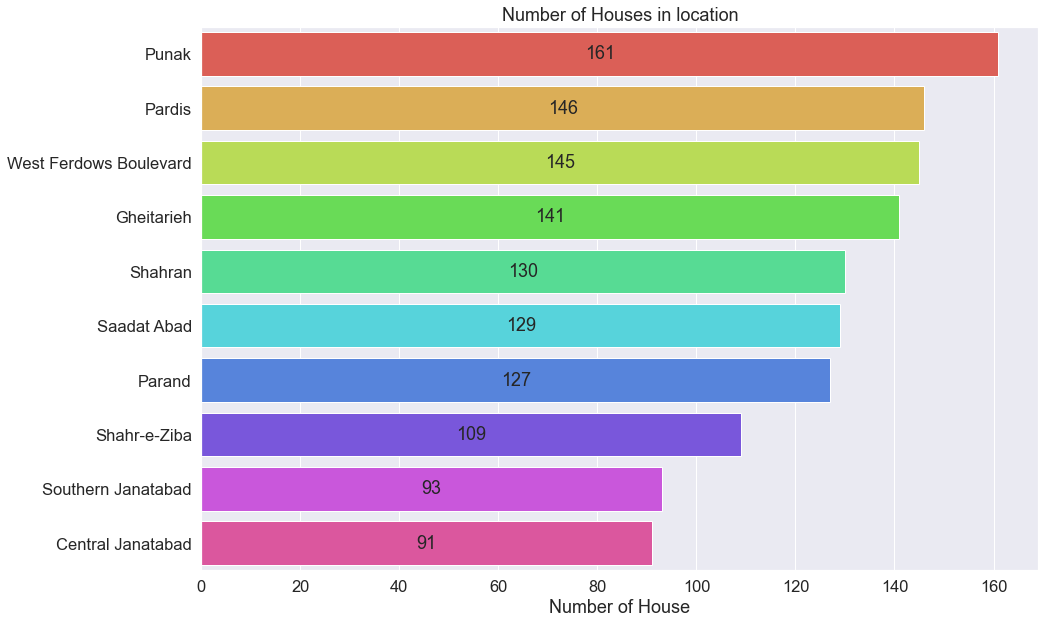

In [15]:
addr = housePrice['Address'].value_counts().copy()
addr = addr[:10]
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x=addr.values, y=addr.index,ax=ax,  palette = 'hls',
           
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd' )
ax.bar_label(ax.containers[0], label_type='center')
plt.xlabel('Number of House')
plt.title('Number of Houses in location')

# House AREA 

In [16]:
housePrice['Area'].sort_values().head(20)

807               1,000 
709      16,160,000,000 
2802      2,550,000,000 
570       3,310,000,000 
2171              3,600 
1604      8,400,000,000 
934                  100
1080                 100
1595                 100
1597                 100
3137                 100
1608                 100
180                  100
2831                 100
1590                 100
2332                 100
2943                 100
192                  100
2733                 100
1655                 100
Name: Area, dtype: object

Text(0.5, 1.0, 'Amount of Area a House Occuped')

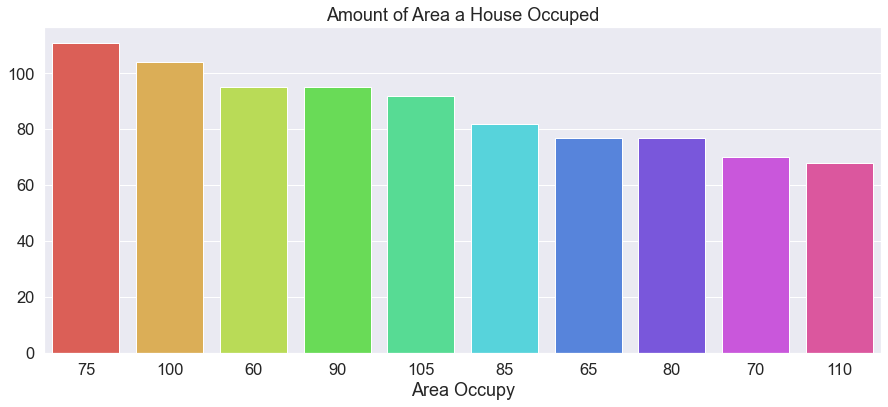

In [17]:
aR = housePrice['Area'].value_counts().copy()
aR = aR[:10]
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=aR.index, y=aR.values,ax=ax, palette = 'hls',
           
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd' )
plt.xlabel('Area Occupy')
plt.title('Amount of Area a House Occuped')

# PARKING, WAREHOUSE, ELEVATOR AVAILABILITY

True     84.79
False    15.21
Name: Parking, dtype: float64
True     91.46
False     8.54
Name: Warehouse, dtype: float64
True     78.73
False    21.27
Name: Elevator, dtype: float64


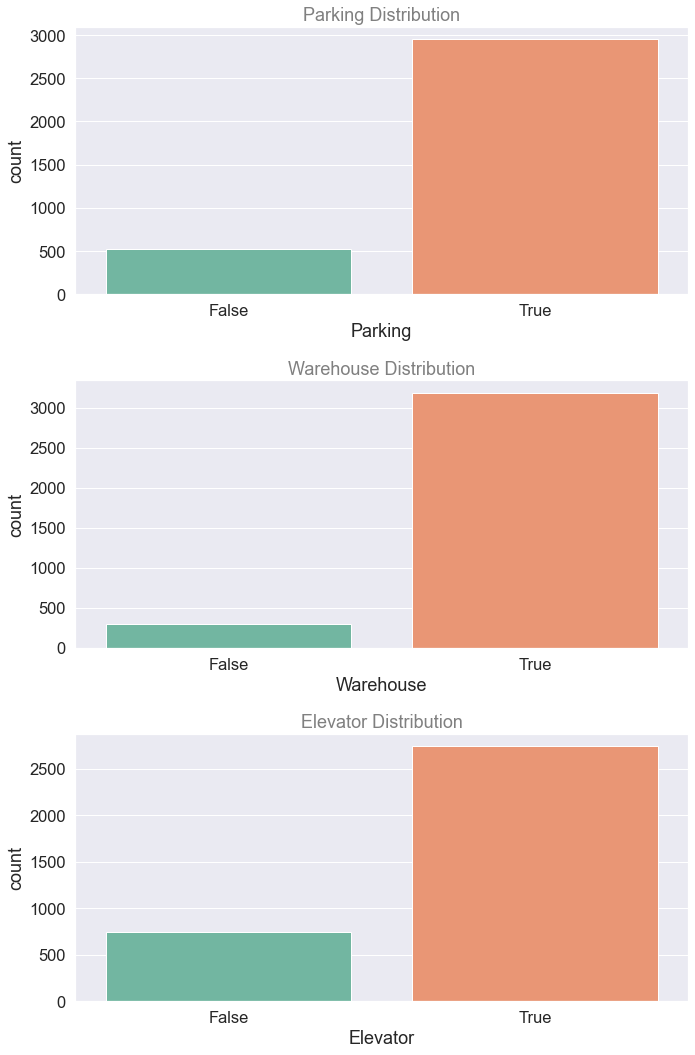

In [18]:
print (f'{round(housePrice["Parking"].value_counts(normalize=True)*100,2)}')
print (f'{round(housePrice["Warehouse"].value_counts(normalize=True)*100,2)}')
print (f'{round(housePrice["Elevator"].value_counts(normalize=True)*100,2)}')

        
boo = ['Parking', 'Warehouse', 'Elevator']
plt.figure(figsize=(10,15))
for inx , col in enumerate(boo):
    plt.subplot(3,1,inx+1)
    sns.countplot(x=col,data=housePrice , palette='Set2')
    plt.title(f'{col} Distribution' , color='gray')
    plt.tight_layout()

# BIVARIATE ANALYSIS

## NUMERICAL FEATURE

### AREA VS PRICE

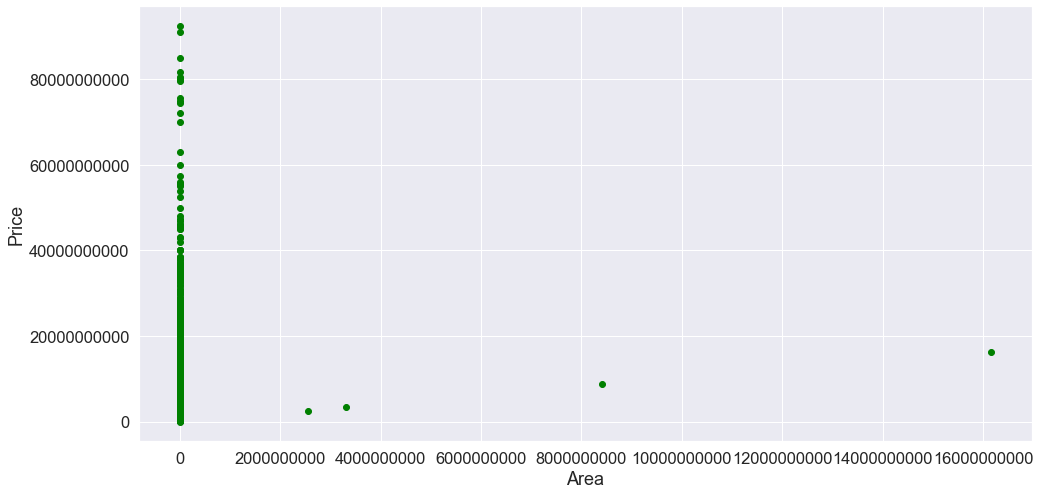

In [19]:
#converting Area data type and replacing space with ,
housePri=housePrice
housePri["Area"] = housePri["Area"].apply(lambda x: float(x.split()[0].replace(',', '')))
housePri["Area"].astype(str).astype(float)

#ploting Price against Area
plt.figure(figsize = (16,8))
plt.scatter(housePri['Area'], housePri['Price'],  color='green')
plt.xlabel("Area")
plt.ylabel("Price")
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [20]:
#Raw Dataset sorted based on Area
housePri.sort_values(by="Area", ascending=False).head(15)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
709,1.616000e+10,3,True,True,True,Pasdaran,1.616000e+10,538666.67
1604,8.400000e+09,2,True,True,True,Gheitarieh,8.700000e+09,290000.00
570,3.310000e+09,2,True,True,True,Ostad Moein,3.310000e+09,110333.33
2802,2.550000e+09,2,True,True,True,Central Janatabad,2.550000e+09,85000.00
2171,3.600000e+03,2,False,False,False,Shahryar,9.720000e+09,324000.00
807,1.000000e+03,2,True,True,False,Damavand,7.000000e+09,233333.33
1694,9.290000e+02,5,True,True,False,Zafar,8.000000e+10,2666666.67
1974,9.000000e+02,3,True,True,False,Damavand,8.500000e+09,283333.33
573,8.630000e+02,2,True,True,True,Gheitarieh,7.830000e+09,261000.00
831,7.500000e+02,5,True,True,True,Mahmoudieh,7.500000e+10,2500000.00


In [21]:
#getting the list of Houses with this outrageous Area measurement
housePri[housePri['Area']>3500]

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
570,3.310000e+09,2,True,True,True,Ostad Moein,3.310000e+09,110333.33
709,1.616000e+10,3,True,True,True,Pasdaran,1.616000e+10,538666.67
1604,8.400000e+09,2,True,True,True,Gheitarieh,8.700000e+09,290000.00
2171,3.600000e+03,2,False,False,False,Shahryar,9.720000e+09,324000.00
2802,2.550000e+09,2,True,True,True,Central Janatabad,2.550000e+09,85000.00


## CATEGORICAL FEATURES

In [22]:
def cat_v_tG(hou, feature):
    plt.grid(True)
    ax = sns.boxenplot(data=hou, x=feature, y='Price')
    ax.set_title(f'{feature} vs price', fontdict={'fontsize': 18})

# draw the countplot of a categorical variable
def cat_cplot(hou, feature):
    plt.grid(True)
    ax = sns.countplot(x=hou[feature])
    ax.set_title(f'{feature}\'s count', fontdict={'fontsize': 18})
    

cat_features = ['Room','Parking','Warehouse','Elevator']

### ROOM VS PRICE

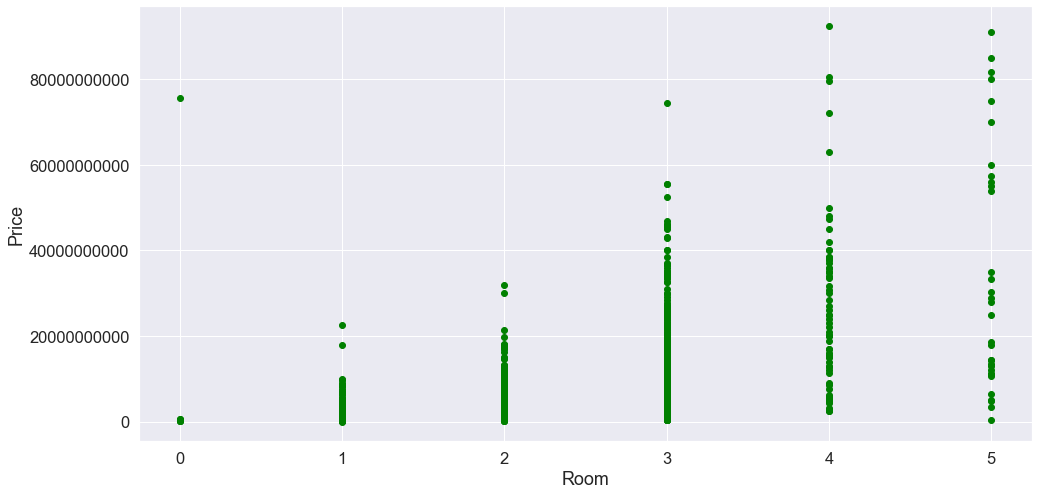

In [23]:
#ROOM VS PRICE
plt.figure(figsize = (16,8))
plt.scatter(housePri['Room'], housePri['Price'],  color='green')
plt.xlabel("Room")
plt.ylabel("Price")
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

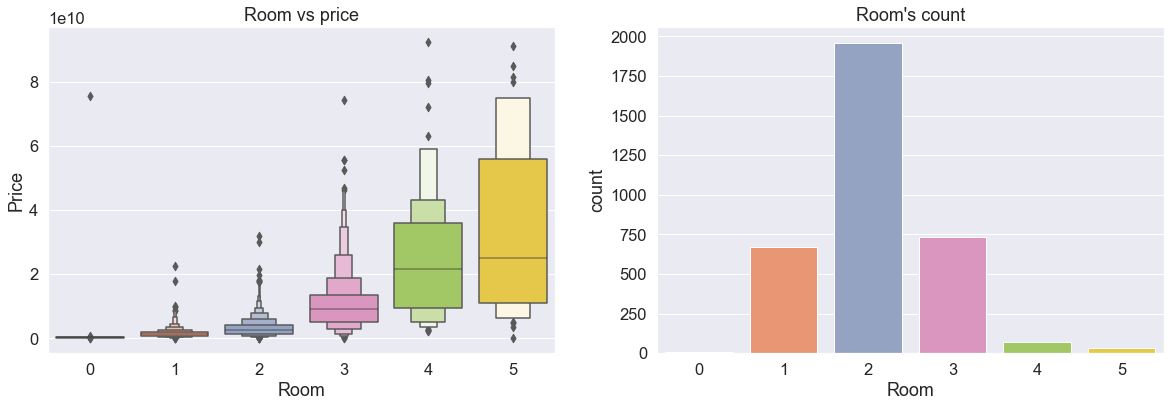

In [24]:
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
cat_v_tG(housePri, cat_features[0])

plt.subplot(1, 2, 2)
cat_cplot(housePri, cat_features[0])
plt.show() 

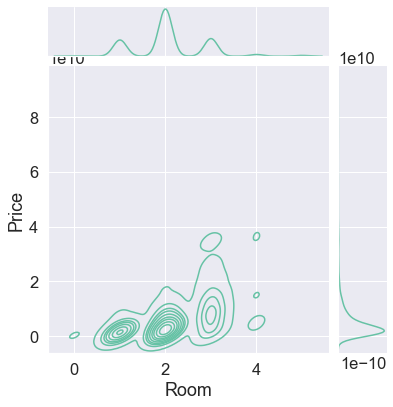

In [25]:
sns.jointplot(x = "Room", y = "Price", kind = "kde", data = housePri)

In [26]:
housePri[(housePri['Room']== 0) & (housePri['Price']> 20000000000)]

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
3107,630.0,0,False,False,False,Tajrish,7.560000e+10,2520000.0


In [27]:
housePri[(housePri['Address']== "Tajrish")]

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
355,110.0,2,True,True,True,Tajrish,6.600000e+09,220000.00
1148,115.0,2,True,True,True,Tajrish,8.200000e+09,273333.33
2584,300.0,4,True,True,True,Tajrish,9.000000e+09,300000.00
2769,100.0,2,True,True,True,Tajrish,5.700000e+09,190000.00
2831,100.0,2,True,True,True,Tajrish,5.700000e+09,190000.00
3096,150.0,3,True,True,True,Tajrish,1.275000e+10,425000.00
3107,630.0,0,False,False,False,Tajrish,7.560000e+10,2520000.00


### Parking VS Price

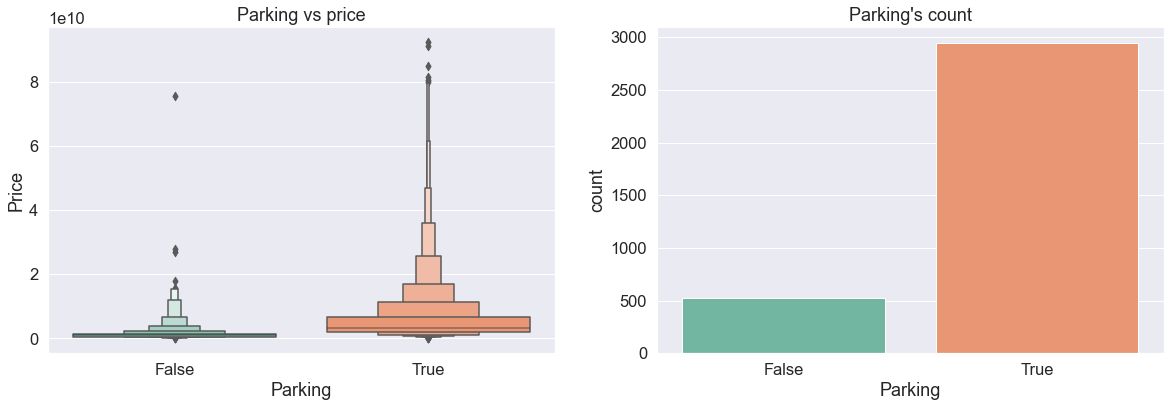

In [28]:
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
cat_v_tG(housePri, cat_features[1])

plt.subplot(1, 2, 2)
cat_cplot(housePri, cat_features[1])
plt.show() 

### Warehouse vs Price

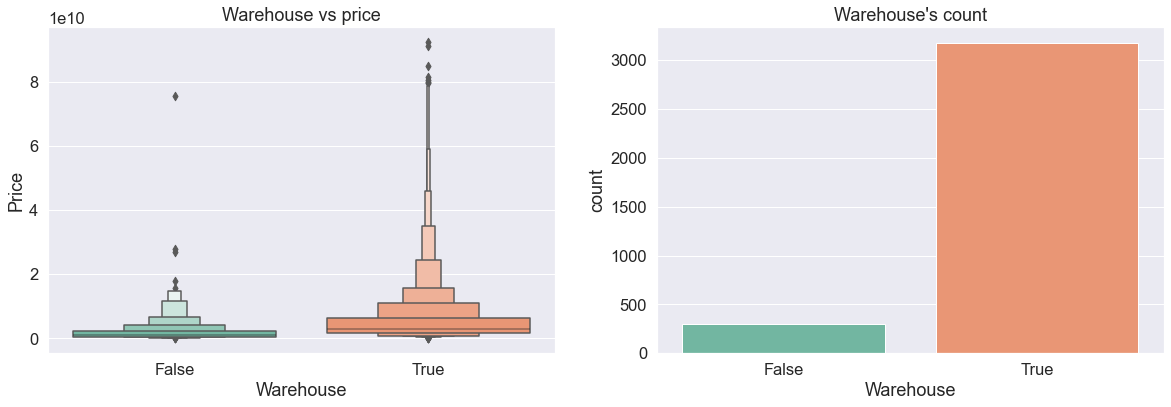

In [29]:
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
cat_v_tG(housePri, cat_features[2])

plt.subplot(1, 2, 2)
cat_cplot(housePri, cat_features[2])
plt.show() 

### Elevator vs Price

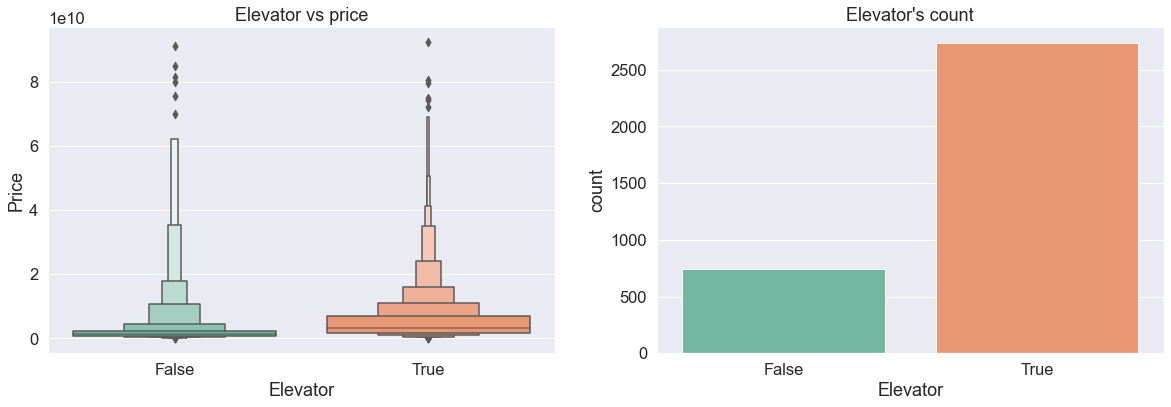

In [30]:
plt.figure(figsize=(20, 6))
sns.set_palette('Set2')
plt.subplot(1, 2, 1)
cat_v_tG(housePri, cat_features[3])

plt.subplot(1, 2, 2)
cat_cplot(housePri, cat_features[3])
plt.show() 

array([[<AxesSubplot:title={'center':'Area'}>,
        <AxesSubplot:title={'center':'Room'}>],
       [<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Price(USD)'}>]], dtype=object)

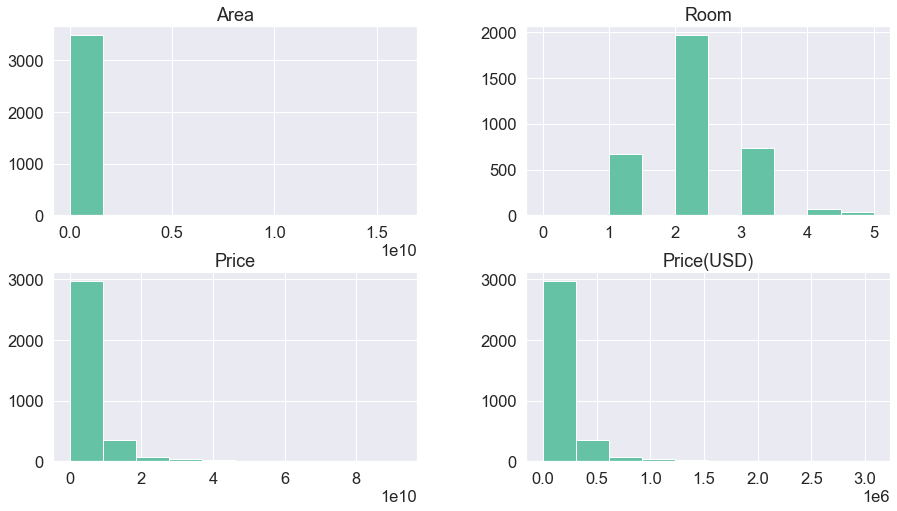

In [31]:
housePri.hist(figsize=(15,8))

<AxesSubplot:>

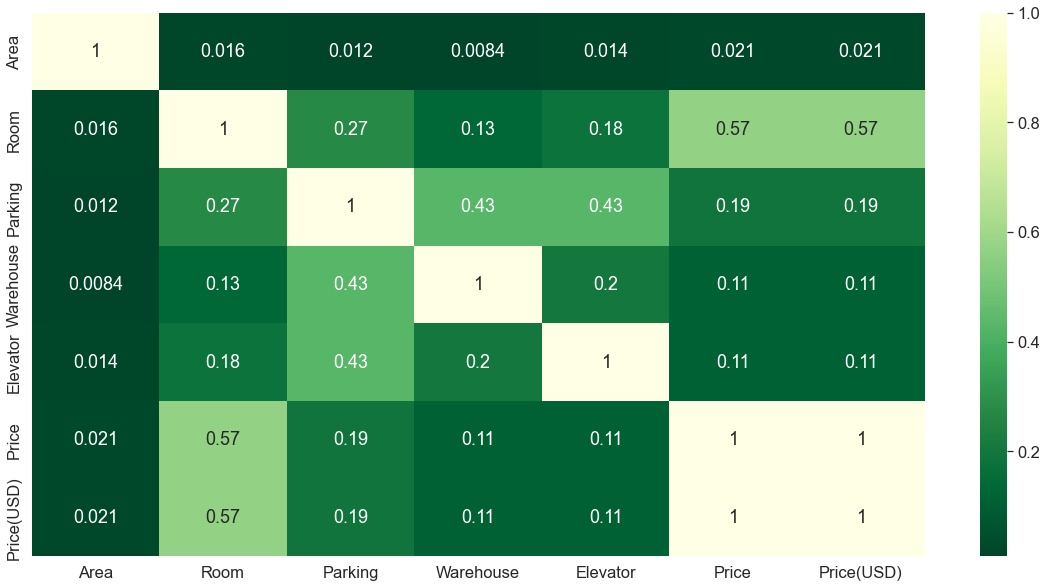

In [32]:
plt.figure(figsize=(20,10))
sns.heatmap(housePri.corr(), annot=True, cmap="YlGn_r")

# DATA PRE-PROCESSING

In [33]:
#copying the orginal dataset
housePri_copy=housePri.copy()

In [34]:
#Converting Boolean type to integers
housePri["Parking"] =housePri['Parking'].astype('int')
housePri["Warehouse"] = housePri['Warehouse'].astype('int')
housePri["Elevator"] = housePri['Elevator'].astype('int')

In [35]:
housePri.drop(['Price(USD)'], axis=1, inplace=True)
housePri = housePri.drop([709, 1604, 570, 2802])
housePri

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63.0,1,1,1,1,Shahran,1.850000e+09
1,60.0,1,1,1,1,Shahran,1.850000e+09
2,79.0,2,1,1,1,Pardis,5.500000e+08
3,95.0,2,1,1,1,Shahrake Qods,9.025000e+08
4,123.0,2,1,1,1,Shahrake Gharb,7.000000e+09
...,...,...,...,...,...,...,...
3474,86.0,2,1,1,1,Southern Janatabad,3.500000e+09
3475,83.0,2,1,1,1,Niavaran,6.800000e+09
3476,75.0,2,0,0,0,Parand,3.650000e+08
3477,105.0,2,1,1,1,Dorous,5.600000e+09


In [36]:
housePri=housePri.dropna()
housePri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3452 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3452 non-null   float64
 1   Room       3452 non-null   int64  
 2   Parking    3452 non-null   int32  
 3   Warehouse  3452 non-null   int32  
 4   Elevator   3452 non-null   int32  
 5   Address    3452 non-null   object 
 6   Price      3452 non-null   float64
dtypes: float64(2), int32(3), int64(1), object(1)
memory usage: 175.3+ KB


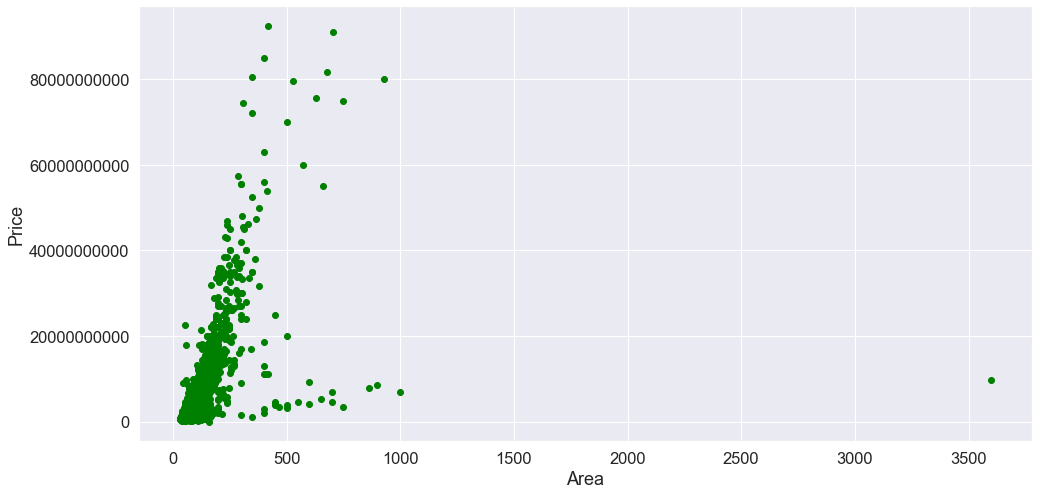

In [37]:
#AREA VS PRICE
plt.figure(figsize = (16,8))
plt.scatter(housePri['Area'], housePri['Price'],  color='green')
plt.xlabel("Area")
plt.ylabel("Price")
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [38]:
#getting the list of Houses above 3500 in dimension 
housePri[housePri['Area']>3500]

,Area,Room,Parking,Warehouse,Elevator,Address,Price
2171,3600.0,2,0,0,0,Shahryar,9.720000e+09


In [39]:
housePri.skew()

Area         17.605814
Room          0.624244
Parking      -1.932278
Warehouse    -2.973597
Elevator     -1.403149
Price         4.767098
dtype: float64

<AxesSubplot:xlabel='Price'>

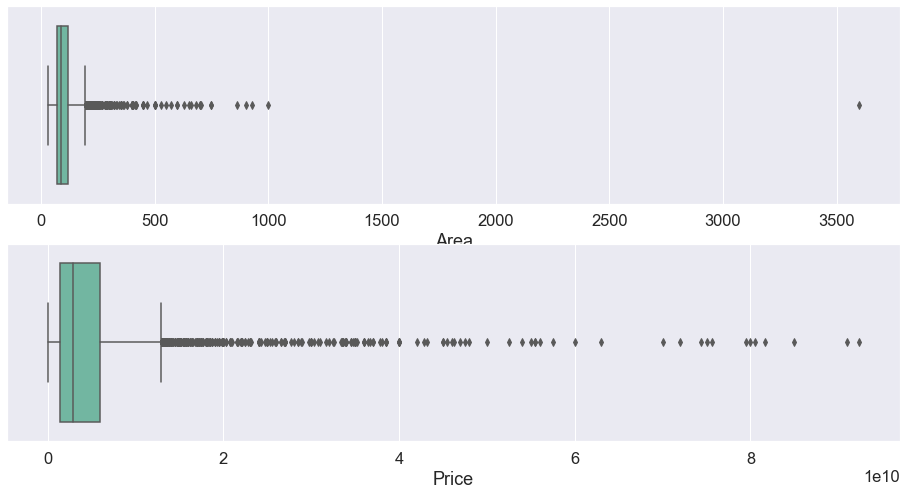

In [40]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x =housePri['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = housePri['Price'])

Using skewness and box plot function reveal more information on the hinden outliers. The result shows that there are still outliers in price as well,Even after removing some outreagous values from the data. To remove this outliers by writing simple function.

In [41]:
#REMOVING OUTLIERS
#i want to get the value of the outliers using interquaritle ranges
#i wil define interquartiles range functions that will give me the IQR values and also detect values for upper and lower quartiles
def Up_lw_qrt(data):
    Qrt1=np.percentile(data,25)
    Qrt3=np.percentile(data,75)
    IQR=Qrt3 - Qrt1
    #i want to get the lower and uper quartile now
    lQrt=Qrt1 - (1.5 * IQR)
    UQrt=Qrt3 + (1.5 * IQR)
    return lQrt,UQrt

#i want to show the lower and upper uartiel for this two column Price and Area
l_area,u_area=Up_lw_qrt(housePri.Area)
l_price,u_price=Up_lw_qrt(housePri.Price)

print(f"Lower Price limit is:{l_price:,}")
print(f"Uper Price limit is:{u_price:,}")
print(f"Lower Area limit is:{l_area:0.2f}")
print(f"Uper Area limit is:{u_area:0.2f}")

#area outiers

a_outliers=np.where(housePri.Area > u_area)
p_outliers=np.where(housePri.Price > u_price) 
total_outliers= np.union1d(a_outliers,p_outliers) 
print(f"Number of Area Outliers:{len(housePri.Area.iloc[a_outliers])}")
print(f"Number of Price Outliers:{len(housePri.Price.iloc[p_outliers])}")
print(f"Number of Total Outliers:{len(housePri.Area.iloc[total_outliers])}")

housePri.Area.iloc[a_outliers]=np.nan
housePri.Price.iloc[p_outliers]=np.nan


Lower Price limit is:-5,450,625,000.0
Uper Price limit is:12,870,375,000.0
Lower Area limit is:-7.50
Uper Area limit is:196.50
Number of Area Outliers:240
Number of Price Outliers:309
Number of Total Outliers:363


In [42]:
housePri=housePri.dropna(axis=0)
housePri.isnull().sum()

Area         0
Room         0
Parking      0
Warehouse    0
Elevator     0
Address      0
Price        0
dtype: int64

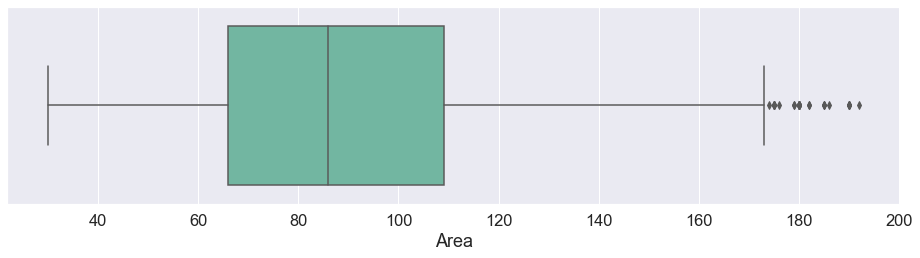

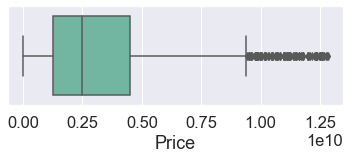

Here is the skewness after droping outliers Area         0.672756
Room         0.163801
Parking     -1.798618
Warehouse   -2.901748
Elevator    -1.393130
Price        1.285909
dtype: float64


In [43]:
#i want to plot the new area and price varibale to check and confirm that the outliers has been removed
plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
sns.boxplot(x=housePri.Area)
plt.show()

plt.subplot(2,1,2)
sns.boxplot(x=housePri.Price)
plt.show()

print("Here is the skewness after droping outliers",housePri.skew())
#let me also check cross correlation of the data using pairplot of the whole dataset


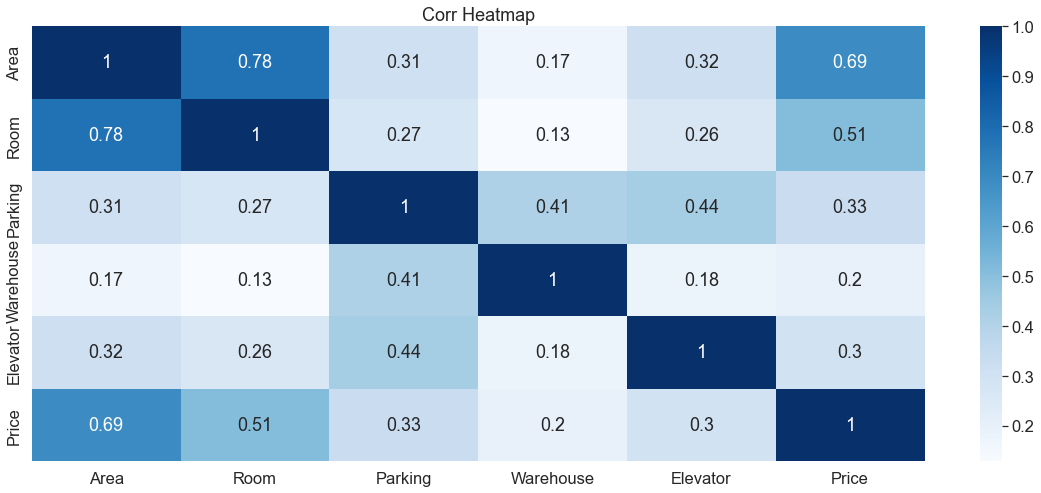

In [44]:
# heatmap of correlation between features
plt.figure(figsize=(20, 8))
ax = sns.heatmap(housePri.corr(), annot=True, cmap='Blues')
ax.set_title('Corr Heatmap', fontdict={'fontsize': 18})
plt.show()

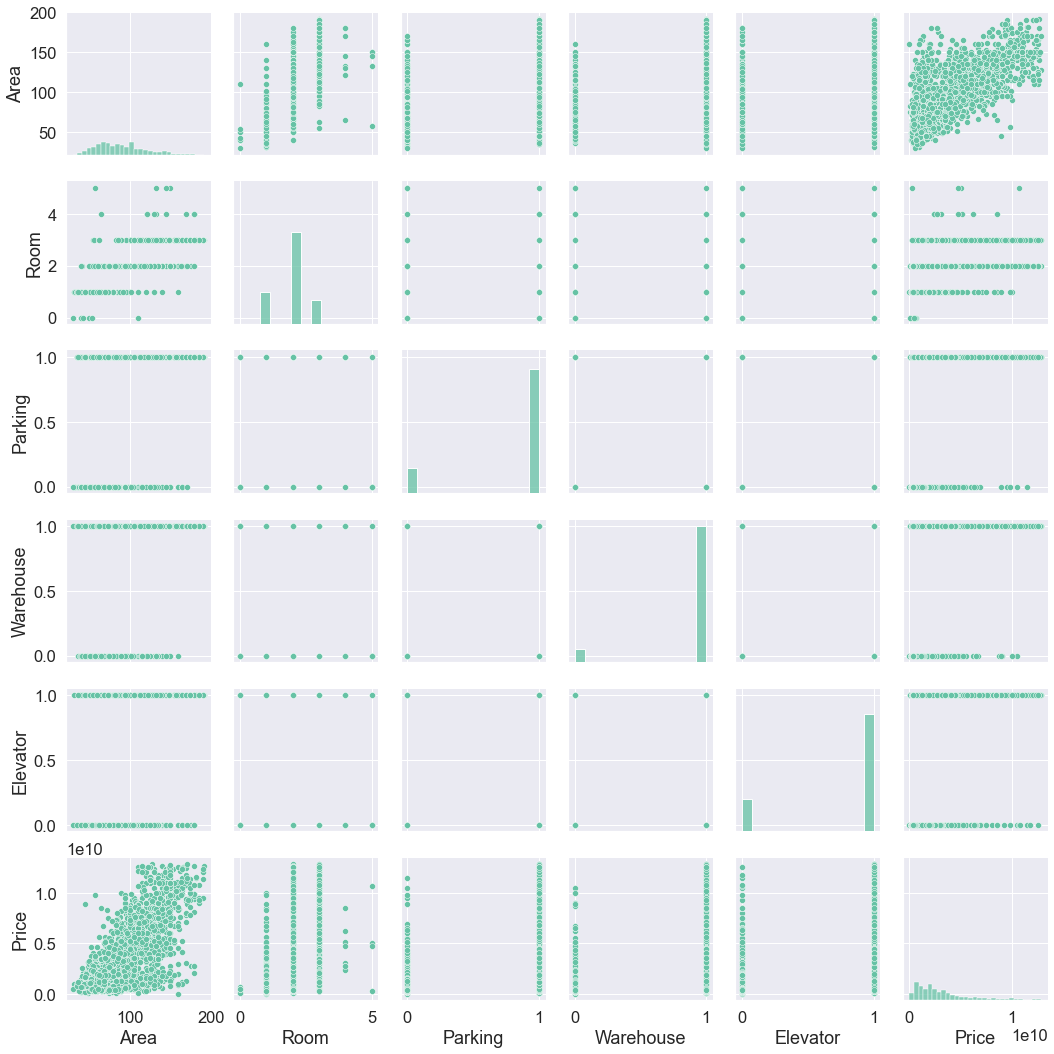

In [45]:
#let me also check cross correlation of the data using pairplot of the whole dataset
sns.pairplot(housePri)

## FEATURE ENGINEERING

In [46]:
AreaNewFeat = []

for i in housePri['Area']:
    if i <= 30:
        AreaNewFeat.append("Small")

    elif (i > 30 and i<=90):
        AreaNewFeat.append("Under Mean")

    elif (i>90 and i <= 120):
        AreaNewFeat.append("Upper Mean")

    elif i > 120:
        AreaNewFeat.append("High")
    else:
            AreaNewFeat.append(np.nan)

housePri["AreaSize"] = AreaNewFeat

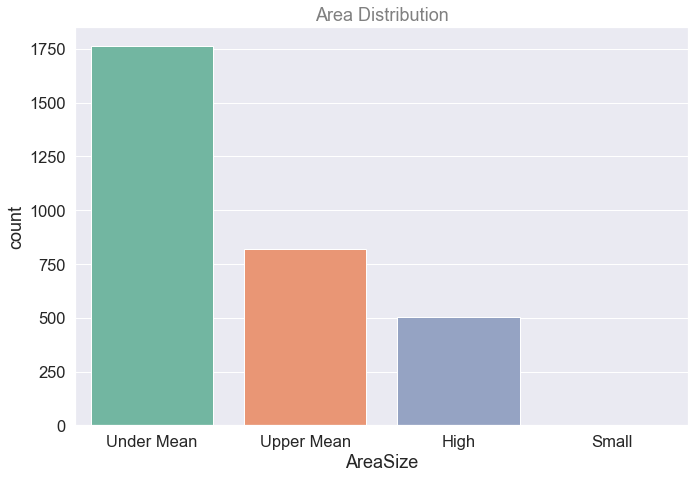

In [47]:
plt.figure(figsize=(10,7))
sns.countplot(x="AreaSize" , data= housePri)
plt.title("Area Distribution" , color='gray')
plt.tight_layout()

In [48]:
PriceNewFeat = []

H25 = housePri['Price'].describe()[4]
H50 = housePri['Price'].describe()[5]
H75 = housePri['Price'].describe()[6]

for i in housePri['Price']:

    if    i <= H25:
        PriceNewFeat.append("Cheap")

    elif (i > H25 and i<= H50):
        PriceNewFeat.append("Under Mean")

    elif (i > H50 and i <= H75):
       PriceNewFeat.append("Upper Mean")

    elif  i > H75:
        PriceNewFeat.append("Expensive")

    else:
        PriceNewFeat.append(np.nan)

housePri["PriceLevel"] = PriceNewFeat

<AxesSubplot:xlabel='PriceLevel', ylabel='count'>

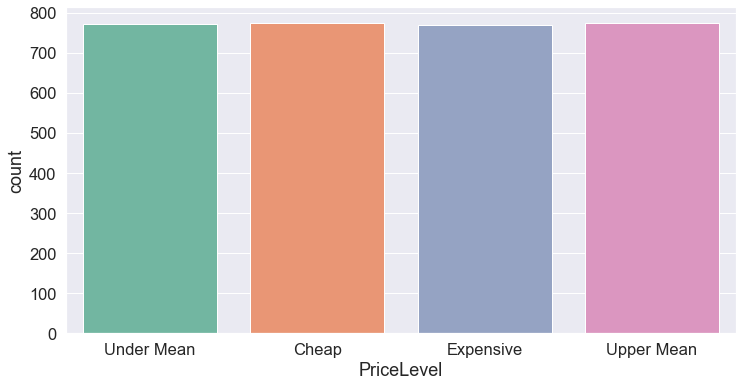

In [49]:
plt.figure(figsize=(12,6))
sns.countplot(x='PriceLevel' , data = housePri )

## RESEACH QUESTIONS

### 4.1 WHAT IS BEING ANALYSED?

1. Aim and Objectives of this reseach analysis is to develop a machine learning model to predict the price of houses

2. The project focussed on supervised learning techniques using regression methods
 

## 4.4 How is it being analysed?

1. Regression Analysis:
    -----------------------
        The target variable is House Price(descrete numerical data), which is dependant variable and other columns area, room, parking, warehouse, elevator and location are independent variable. We perform regression analysis to identify the relation between these dependent and independent variables and build our model. This model will then predict the price information for the given independent variables(features).

### 4.4.1 Suitable Algorithms - Regrerssion Analysis

## DATA PREPARATION FOR REGRESSION

In [50]:
housePri["Area"] =housePri['Area'].astype('int')
pd.options.display.float_format = '{:.0f}'.format
#housePri["Price"] =housePri['Price'].astype('int')
housePri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3089 entries, 0 to 3478
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3089 non-null   int32  
 1   Room        3089 non-null   int64  
 2   Parking     3089 non-null   int32  
 3   Warehouse   3089 non-null   int32  
 4   Elevator    3089 non-null   int32  
 5   Address     3089 non-null   object 
 6   Price       3089 non-null   float64
 7   AreaSize    3089 non-null   object 
 8   PriceLevel  3089 non-null   object 
dtypes: float64(1), int32(4), int64(1), object(3)
memory usage: 257.6+ KB


In [51]:
housePri.head(15)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,AreaSize,PriceLevel
0,63,1,1,1,1,Shahran,1850000000,Under Mean,Under Mean
1,60,1,1,1,1,Shahran,1850000000,Under Mean,Under Mean
2,79,2,1,1,1,Pardis,550000000,Under Mean,Cheap
3,95,2,1,1,1,Shahrake Qods,902500000,Upper Mean,Cheap
4,123,2,1,1,1,Shahrake Gharb,7000000000,High,Expensive
5,70,2,1,1,0,North Program Organization,2050000000,Under Mean,Under Mean
6,87,2,1,1,1,Pardis,600000000,Under Mean,Cheap
7,59,1,1,1,1,Shahran,2150000000,Under Mean,Under Mean
8,54,2,1,1,0,Andisheh,493000000,Under Mean,Cheap
9,71,1,1,1,1,West Ferdows Boulevard,2370000000,Under Mean,Under Mean


### GET DUMMY FOR THE ADDRESS

In [52]:

addr_dum = pd.get_dummies(housePri[['Address','AreaSize','PriceLevel']])
housePrice = housePri.merge(addr_dum, left_index = True, right_index = True)
housePrice.drop(columns = {'Address','AreaSize','PriceLevel'}, inplace = True)
housePrice.head(10)

,Area,Room,Parking,Warehouse,Elevator,Price,Address_Abazar,Address_Abbasabad,Address_Abuzar,Address_Afsarieh,...,Address_Zargandeh,Address_Zibadasht,AreaSize_High,AreaSize_Small,AreaSize_Under Mean,AreaSize_Upper Mean,PriceLevel_Cheap,PriceLevel_Expensive,PriceLevel_Under Mean,PriceLevel_Upper Mean
0,63,1,1,1,1,1850000000,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,60,1,1,1,1,1850000000,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,79,2,1,1,1,550000000,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,95,2,1,1,1,902500000,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,123,2,1,1,1,7000000000,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,70,2,1,1,0,2050000000,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,87,2,1,1,1,600000000,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7,59,1,1,1,1,2150000000,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
8,54,2,1,1,0,493000000,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
9,71,1,1,1,1,2370000000,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### SPLIT DATA TO TARGET AND INPUT VARIABLES


In [53]:
X=housePrice.drop(['Price'], axis=1)
Y=housePrice['Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2, random_state = 0)

print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2471, 200)
shape of y train: (2471,)
shape of x test: (618, 200)
shape of y train: (618,)


### DATA SCALING 


In [54]:
#let scale the x_train and x_test
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
Model_Name  = []
Train_score = []
Test_score  = []
MSE_s   = []
RMSE_s  = []
MAE_s=[]
Accuracy=[]

In [56]:
def find_param (model, parameters):
      
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    
    train_score =grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    model_name = str(model).split('(')[0]
    
    Model_Name.append(model_name)
    Train_score.append(train_score)
    Test_score.append(test_score)
    Accuracy.append(round(test_score*100,1))
    MSE_s.append(MSE)
    RMSE_s.append(RMSE)
    MAE_s.append(MAE)
    
    
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print(f"MSE is {MSE:,} for {model_name} model.")
    #print(y_pred)
    print("--" * 10)
    
           
    return train_score, test_score, RMSE,MSE, y_pred

## RIDGE REGRESSOR MODEL

In [57]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
ridge_para = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

rg_train_score, rg_test_score, rg_RMSE,rg_MSE, y_preRig = find_param(ridge, ridge_para)

The best parameters for Ridge model is: {'alpha': 10}
--------------------
(R2 score) in the training set is 91.32% for Ridge model.
(R2 score) in the testing set is 90.96% for Ridge model.
RMSE is 830,286,604.5457253 for Ridge model.
MSE is 6.893758456880698e+17 for Ridge model.
--------------------


## LASSO REGRESSOR

In [58]:
lassoReg = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
las_para = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasTrain_score, lasTest_score, lasRMSE,lasMSE, las_y_predL = find_param(lassoReg,las_para)

The best parameters for Lasso model is: {'alpha': 10}
--------------------
(R2 score) in the training set is 91.32% for Lasso model.
(R2 score) in the testing set is 90.97% for Lasso model.
RMSE is 829,480,774.3388903 for Lasso model.
MSE is 6.880383549978451e+17 for Lasso model.
--------------------


## RANDOM FOREST REGRESSOR MODEL

In [59]:
forest= RandomForestRegressor(random_state = 1, n_jobs = -1)
param_forest = {'min_samples_split': [2,4],
            'max_depth': [None,4,8],
            'n_estimators' : [100,200,300],'max_features':[0.8,0.9]}

rfr_train_score, rfr_test_score, rfr_RMSE,rfr_MSE, y_pre = find_param(forest, param_forest)


The best parameters for RandomForestRegressor model is: {'max_depth': None, 'max_features': 0.8, 'min_samples_split': 4, 'n_estimators': 100}
--------------------
(R2 score) in the training set is 97.92% for RandomForestRegressor model.
(R2 score) in the testing set is 93.58% for RandomForestRegressor model.
RMSE is 699,743,136.9846356 for RandomForestRegressor model.
MSE is 4.896404577570985e+17 for RandomForestRegressor model.
--------------------


## XG BOOST REGRESSOR

In [60]:
xgboost = XGBRegressor(n_jobs = -1)
param_xgboost = {'n_estimators': [100,300],
             'learning_rate': [0.1,0.05],
             'subsample': [0.75],
             'colsample_bytree': [1],
             'max_depth': [3,4,5],
             'gamma': [0]}

xgb_train_score, xgb_test_score, xgb_RMSE,xgb_MSE, y_preX = find_param(xgboost, param_xgboost)

The best parameters for XGBRegressor model is: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.75}
--------------------
(R2 score) in the training set is 95.62% for XGBRegressor model.
(R2 score) in the testing set is 93.39% for XGBRegressor model.
RMSE is 710,013,902.3680446 for XGBRegressor model.
MSE is 5.0411974155589926e+17 for XGBRegressor model.
--------------------


## ElasticNet model

In [61]:
elas = ElasticNet(random_state = 1) # Linear regression with combined L1 and L2 priors as regularizer.
ePram = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]}

eTtrain_score, eTest_score, eRMSE,eMSE, y_predE = find_param(elas, ePram)

The best parameters for ElasticNet model is: {'alpha': 0.1, 'l1_ratio': 0.8}
--------------------
(R2 score) in the training set is 91.30% for ElasticNet model.
(R2 score) in the testing set is 90.88% for ElasticNet model.
RMSE is 833,956,532.4863738 for ElasticNet model.
MSE is 6.954834980766962e+17 for ElasticNet model.
--------------------


## KN NEIGHBOUR REGRESSOR

In [62]:
Kregress = KNeighborsRegressor(n_jobs = -1)
kPram = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knTrain_score, knTest_score, knRMSE,knMSE,y_predKn = find_param(Kregress, kPram)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 20, 'weights': 'distance'}
--------------------
(R2 score) in the training set is 99.43% for KNeighborsRegressor model.
(R2 score) in the testing set is 89.49% for KNeighborsRegressor model.
RMSE is 895,013,038.9223047 for KNeighborsRegressor model.
MSE is 8.01048339840939e+17 for KNeighborsRegressor model.
--------------------


In [63]:
## Decision Tree Regressor

In [64]:
DecTr = DecisionTreeRegressor(random_state = 1)
dec_param = {'min_samples_split': [2,3,4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_train_score, dtr_test_score, dtr_RMSE,dtr_MSE, y_predDec = find_param(DecTr, dec_param)

The best parameters for DecisionTreeRegressor model is: {'min_samples_leaf': 3, 'min_samples_split': 2}
--------------------
(R2 score) in the training set is 95.25% for DecisionTreeRegressor model.
(R2 score) in the testing set is 90.35% for DecisionTreeRegressor model.
RMSE is 857,655,986.6890824 for DecisionTreeRegressor model.
MSE is 7.355737915036236e+17 for DecisionTreeRegressor model.
--------------------


## Neural Network

In [65]:
nn_model = MLPRegressor()
nn_param = \
    {
        "hidden_layer_sizes": [(7,)*3, (19,), (100,), (154,)],
        "activation": ["identity", "logistic", "tanh", "relu"],
        "solver": ["lbfgs"],
        "alpha": [1, 10, 100],
    }
nn_train_score, nn_test_score, nn_RMSE,dtr_MSE, y_predNn = find_param(nn_model, nn_param)

The best parameters for MLPRegressor model is: {'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (19,), 'solver': 'lbfgs'}
--------------------
(R2 score) in the training set is 96.38% for MLPRegressor model.
(R2 score) in the testing set is 92.45% for MLPRegressor model.
RMSE is 758,859,262.6933253 for MLPRegressor model.
MSE is 5.758673805754573e+17 for MLPRegressor model.
--------------------


In [66]:
pd.reset_option("all")
R_data = pd.DataFrame({'Algorithms':Model_Name,
            'Train':Train_score , 
            'Test':Test_score , 
            'Accuracy':Accuracy,
            'MSE' :MSE_s,
            'RMSE':RMSE_s,
            'MAE':MAE_s})
R_data.set_index('Algorithms', inplace=True)
R_data.sort_values(by=['MAE'])


,Train,Test,Accuracy,MSE,RMSE,MAE
Algorithms,,,,,,
RandomForestRegressor,0.979239,0.935768,93.6,4.896405e+17,6.997431e+08,3.924720e+08
XGBRegressor,0.956164,0.933868,93.4,5.041197e+17,7.100139e+08,4.550615e+08
MLPRegressor,0.963829,0.924456,92.4,5.758674e+17,7.588593e+08,4.583499e+08
DecisionTreeRegressor,0.952451,0.903505,90.4,7.355738e+17,8.576560e+08,4.837702e+08
ElasticNet,0.912969,0.908764,90.9,6.954835e+17,8.339565e+08,5.090714e+08
Ridge,0.913214,0.909566,91.0,6.893758e+17,8.302866e+08,5.112731e+08
Lasso,0.913229,0.909741,91.0,6.880384e+17,8.294808e+08,5.123537e+08
KNeighborsRegressor,0.994283,0.894916,89.5,8.010483e+17,8.950130e+08,5.158643e+08


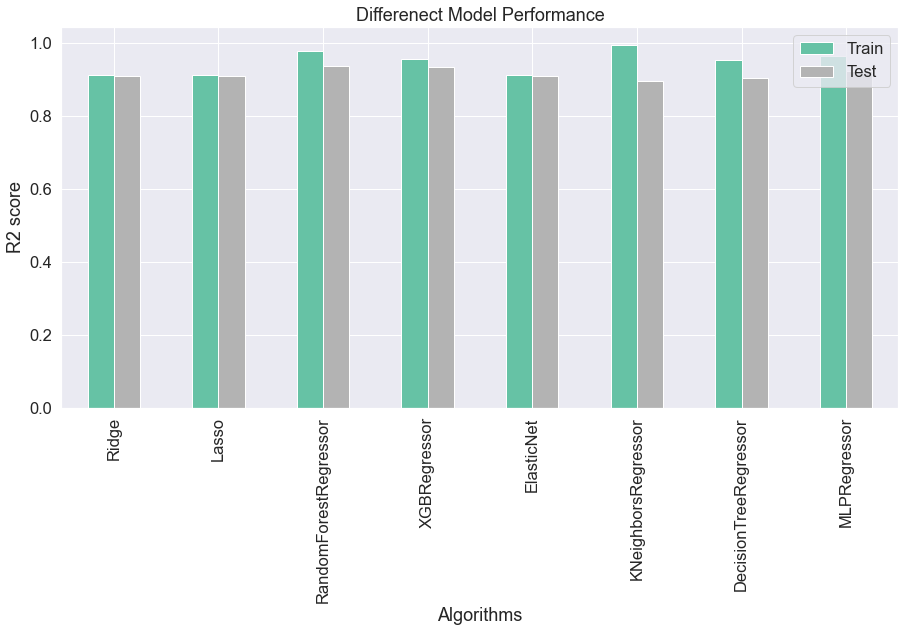

In [68]:
R_data.plot(y = ['Train' , 'Test'] , kind="bar" , figsize=(15,7) ,title="Differenect Model Performance" , colormap="Set2")
plt.ylabel('R2 score')
plt.show()

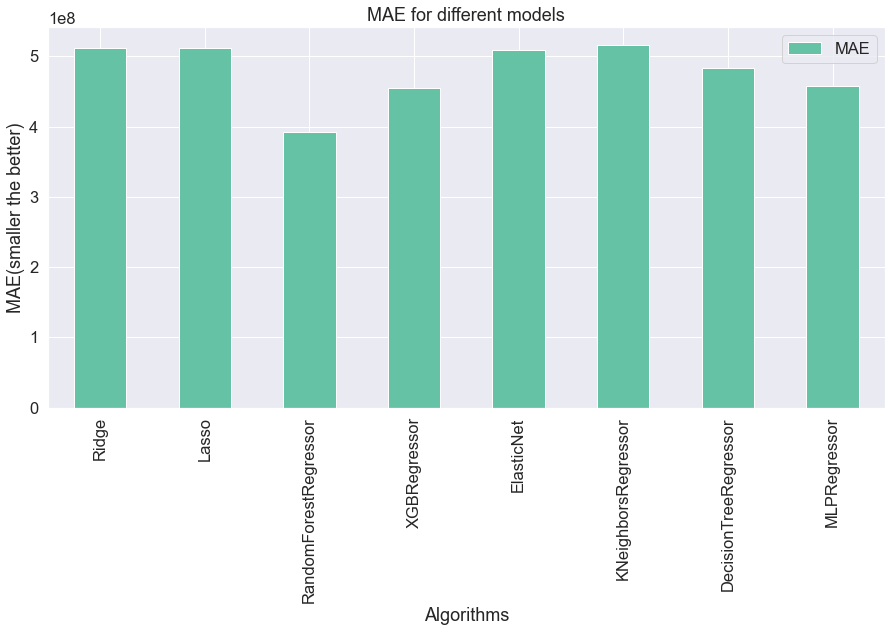

In [69]:
R_data.plot(y = ['MAE'] , kind="bar" , figsize=(15,7) ,title="MAE for different models" )
plt.ylabel("MAE(smaller the better)")
plt.show()